# AAut lab question 2 part 1

## Image classification

# Initial steps
Import libraries

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D
from imblearn.over_sampling import SMOTE

Load data

In [87]:
Xtest1 = np.load('Xtest1.npy')
Xtrain1 = np.load('Xtrain1.npy')
Xtrain1_extra = np.load('Xtrain1_extra.npy')
Ytrain1 = np.load('Ytrain1.npy')
Xtrain1_extra = Xtrain1_extra.reshape(-1, 48, 48, 1)

In [88]:
# Function to plot images
def plot_images(images, labels, num_images=10, extra=0):
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(2, num_images // 2, i + 1)
        plt.imshow(images[i].reshape(48, 48), cmap='gray')
        if extra:
            plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.show()

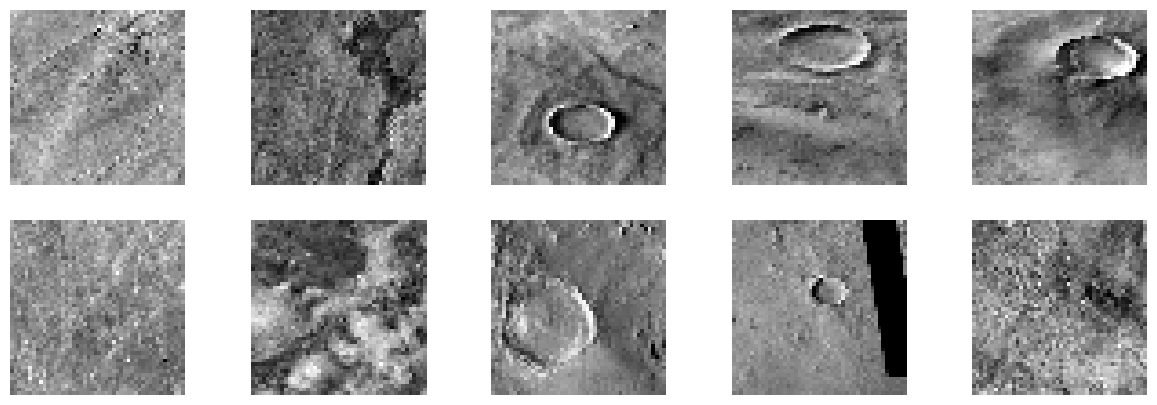

In [92]:
# Plot the first 10 images from the training set
extra = 0
plot_images(Xtrain1_extra, Ytrain1, num_images=10, extra=extra)

Compute SMOTE (Synthetic Minority Over-sampling Technique) to deal with the low quantity of crater data

In [53]:
smote = SMOTE()

Xtrain_resampled, Ytrain_resampled = smote.fit_resample(Xtrain1, Ytrain1)

Xtrain_resampled = Xtrain_resampled.reshape(-1, 48, 48, 1)

Split data into train and test

In [54]:
# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(Xtrain_resampled, Ytrain_resampled, test_size=0.2, random_state=42)

# Convert labels to categorical (binary classification)
y_train_cat = to_categorical(y_train, 2)
y_val_cat = to_categorical(y_val, 2)

## Build CNNs

### CNN

In [55]:
# Build a simple CNN model
model_CNN = Sequential([
    Input(shape=(48, 48, 1)),

    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

### VGG16

In [56]:
# Load VGG16 model with pre-trained weights, excluding the top layers
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

# Freeze the layers of VGG16
for layer in vgg16_base.layers:
    layer.trainable = False

# Add custom layers on top of VGG16
vgg16_model = Sequential([
    Input(shape=(48, 48, 1)),
    Conv2D(3, (1, 1), activation='relu'),  # Convert grayscale to RGB
    vgg16_base,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

### ResNet50

In [57]:
# Load ResNet50 model with pre-trained weights, excluding the top layers
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

# Freeze the layers of ResNet50
for layer in resnet_base.layers:
    layer.trainable = False

# Add custom layers on top of ResNet50
resnet_model = Sequential([
    Input(shape=(48, 48, 1)),
    Conv2D(3, (1, 1), activation='relu'),  # Convert grayscale to RGB
    resnet_base,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

## Train the models

Callbacks

In [58]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1e-5)

### CNN

In [ ]:
# Compile the model
model_CNN.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_CNN = model_CNN.fit(X_train, y_train_cat, validation_data=(X_train, y_train_cat), epochs=20, callbacks=[early_stopping, reduce_lr], batch_size=32)

### VGG16


In [ ]:
vgg16_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the VGG16 model with data augmentation
history_vgg16 = vgg16_model.fit(X_train, y_train_cat, 
                                validation_data=(X_val, y_val_cat), 
                                epochs=20, 
                                callbacks=[early_stopping, reduce_lr], batch_size=32)

### ResNet50

In [ ]:
resnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the ResNet50 model with data augmentation
history_resnet = resnet_model.fit(X_train, y_train_cat, 
                                  validation_data=(X_val, y_val_cat), 
                                  epochs=20, 
                                  callbacks=[early_stopping, reduce_lr], batch_size=32)

## Evaluation of the models

### CNN

In [ ]:
# Evaluate the model on the validation set
y_val_pred_CNN = model_CNN.predict(X_val)
y_val_pred_classes_CNN = np.argmax(y_val_pred_CNN, axis=1)

### VGG16

In [ ]:
# Evaluate the VGG16 model on the validation set
y_val_pred_vgg16 = vgg16_model.predict(X_val)
y_val_pred_classes_vgg16 = np.argmax(y_val_pred_vgg16, axis=1)

### ResNet50

In [ ]:
# Evaluate the ResNet50 model on the validation set
y_val_pred_resnet = resnet_model.predict(X_val)
y_val_pred_classes_resnet = np.argmax(y_val_pred_resnet, axis=1)

In [ ]:
# Calculate F1 Score
f1_CNN = f1_score(y_val, y_val_pred_classes_CNN)
f1_vgg16 = f1_score(y_val, y_val_pred_classes_vgg16)
f1_resnet = f1_score(y_val, y_val_pred_classes_resnet)
print(f"Validation F1 Score: {f1_CNN} (CNN), {f1_vgg16} (VGG16), {f1_resnet} (ResNet50)")

Confusion matrix

In [ ]:
# Compute confusion matrix for CNN
cm_CNN = confusion_matrix(y_val, y_val_pred_classes_CNN)
print("Confusion Matrix for CNN:")
print(cm_CNN)

# Compute confusion matrix for VGG16
cm_vgg16 = confusion_matrix(y_val, y_val_pred_classes_vgg16)
print("Confusion Matrix for VGG16:")
print(cm_vgg16)

# Compute confusion matrix for ResNet50
cm_resnet = confusion_matrix(y_val, y_val_pred_classes_resnet)
print("Confusion Matrix for ResNet50:")
print(cm_resnet)

### Final predictions

In [ ]:
Xtest1 = Xtest1.reshape(-1, 48, 48, 1)
predY_final = model_CNN.predict(Xtest1)
predY_classes_final = np.argmax(predY_final, axis=1)

# Save the predictions with np
np.save('predY_classes_final.npy', predY_classes_final)